In [ ]:
pip install pyswarms

In [ ]:
import numpy as np
import pyswarms as ps
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

2025-03-28 17:30:25,033 - numexpr.utils - INFO - NumExpr defaulting to 2 threads.


In [ ]:
data = load_wine()
X = data.data  # Массив признаков
y = data.target  # Вектор целевых значений
# Разделение данных на обучающую и тестовую выборки (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Определение пространства поиска гиперпараметров
hyperparameter_bounds = {
    'max_depth': (1, 30),           # Максимальная глубина дерева
    'min_samples_split': (2, 30),   # Минимальное число образцов для разделения узла
    'min_samples_leaf': (1, 15),    # Минимальное число образцов в листе
    'criterion_threshold': (0, 1)   # Порог для выбора критерия (gini/entropy)
}

In [ ]:
# Функция преобразования позиции частицы в гиперпараметры
def particle_to_hyperparams(particle):
    """
    Преобразует непрерывные значения частицы в валидные гиперпараметры для CART.

    Аргументы:
        particle (np.array): Вектор позиции частицы в пространстве параметров

    Возвращает:
        dict: Словарь с преобразованными гиперпараметрами
    """
    params = {
        'max_depth': int(np.round(particle[0])),  # Округление до целого числа
        'min_samples_split': int(np.round(particle[1])),
        'min_samples_leaf': int(np.round(particle[2])),
        'criterion': 'entropy' if particle[3] > 0.5 else 'gini'  # Бинарный выбор
    }

    # Корректировка минимальных значений параметров
    params['max_depth'] = max(1, params['max_depth'])  # Глубина не может быть меньше 1
    params['min_samples_split'] = max(2, params['min_samples_split'])  # Минимум 2 образца для разделения
    params['min_samples_leaf'] = max(1, params['min_samples_leaf'])  # Минимум 1 образец в листе

    return params

In [ ]:
# Целевая функция для оптимизации
def objective_function(particles):
    """
    Вычисляет значение целевой функции (1 - accuracy) для каждой частицы.

    Аргументы:
        particles (np.array): Массив частиц (кандидатных решений)

    Возвращает:
        np.array: Массив значений целевой функции для каждой частицы
    """
    scores = []
    for particle in particles:
        try:
            # Преобразование частицы в гиперпараметры
            params = particle_to_hyperparams(particle)

            # Создание и обучение модели дерева решений
            model = DecisionTreeClassifier(
                max_depth=params['max_depth'],
                min_samples_split=params['min_samples_split'],
                min_samples_leaf=params['min_samples_leaf'],
                criterion=params['criterion'],
                random_state=42  # Фиксация random_state для воспроизводимости
            )

            model.fit(X_train, y_train)  # Обучение модели
            y_pred = model.predict(X_test)  # Прогнозирование на тестовых данных
            accuracy = accuracy_score(y_test, y_pred)  # Вычисление точности

            # Преобразование в задачу минимизации (1 - accuracy)
            scores.append(1 - accuracy)
        except:
            # Штраф за невалидные параметры (например, min_samples_split > min_samples_leaf)
            scores.append(2)  # Большое штрафное значение

    return np.array(scores)

In [ ]:
# Конфигурация алгоритма PSO
options = {
    'c1': 0.5,  # Вес когнитивного компонента (личный лучший опыт)
    'c2': 0.3,  # Вес социального компонента (глобальный лучший опыт)
    'w': 0.9    # Коэффициент инерции (сохранение предыдущей скорости)
}

In [ ]:
# Создание оптимизатора PSO
optimizer = ps.single.GlobalBestPSO(
    n_particles=20,     # Количество частиц в рое
    dimensions=4,       # Количество оптимизируемых параметров
    options=options,    # Параметры алгоритма
    bounds= [(1, 2, 1, 0), (30, 30, 15, 1)]  # Границы поиска для каждого параметра
)

In [ ]:
# Запуск процесса оптимизации
best_cost, best_pos = optimizer.optimize(
    objective_function,  # Целевая функция
    iters=50,            # Количество итераций
    verbose=True         # Вывод прогресса
)

2025-03-28 17:32:25,957 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.0556
2025-03-28 17:32:29,167 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.05555555555555558, best pos: [16.10486895 19.99017946 11.54663909  0.2445999 ]


In [ ]:
best_params = particle_to_hyperparams(best_pos)
print("\nЛучшие найденные параметры:")
print(f"max_depth: {best_params['max_depth']}")
print(f"min_samples_split: {best_params['min_samples_split']}")
print(f"min_samples_leaf: {best_params['min_samples_leaf']}")
print(f"criterion: {best_params['criterion']}")
print(f"Accuracy: {1 - best_cost:.4f}")


Лучшие найденные параметры:
max_depth: 16
min_samples_split: 20
min_samples_leaf: 12
criterion: gini
Accuracy: 0.9444


In [ ]:
from pyswarms.utils.plotters import plot_cost_history

<Axes: title={'center': 'Cost History'}, xlabel='Iterations', ylabel='Cost'>

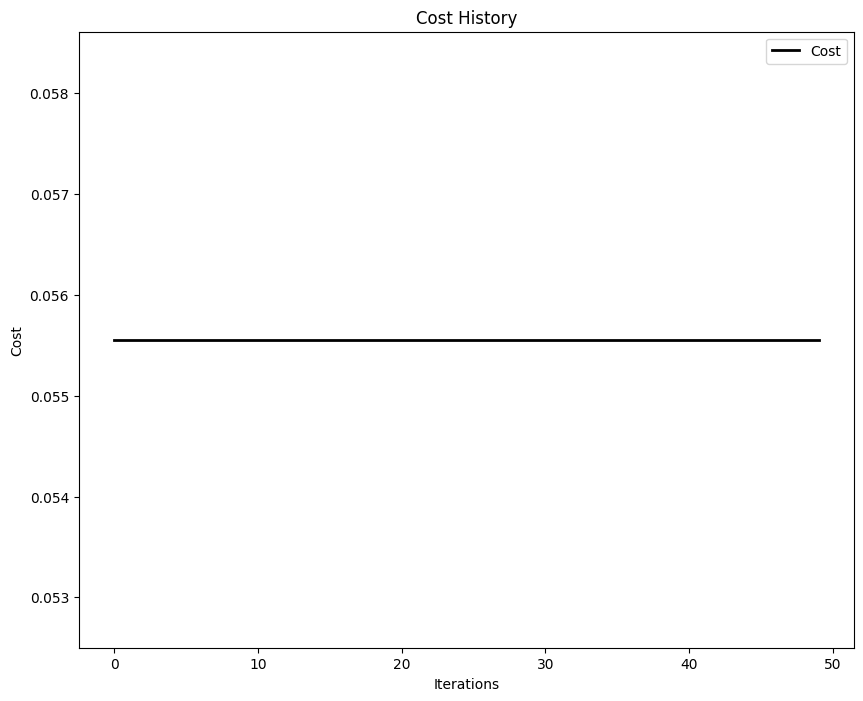

In [ ]:
plot_cost_history(optimizer.cost_history)